<a href="https://colab.research.google.com/github/ras1364/DetectFakeReviewsUsing-Sentence_BERT/blob/main/FakeReviewsWithSentenceEmbeddingUsingSBERT_Ver1_0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
import itertools, nltk, snowballstemmer, re

In [2]:
data = pd.read_csv("/content/sample_data/deceptive-opinion.csv")
data.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [3]:
data['polarity'] = np.where(data['polarity']=='positive',1,0)
data['deceptive'] = np.where(data['deceptive']=='truthful', 1,0)
data.head()

,deceptive,hotel,polarity,source,text
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...


In [4]:
df = data.sample(frac=1)
df.head()

,deceptive,hotel,polarity,source,text
165,1,ambassador,1,TripAdvisor,In a very nice location close to shopping and ...
317,1,sofitel,1,TripAdvisor,I read the reviews on Trip Advisor for this pr...
1042,1,james,0,Web,I just returned from a 2 night stay at the hot...
153,1,homewood,1,TripAdvisor,This hotel was very beautiful. I went with a g...
1101,1,sofitel,0,Web,I would not recommend this hotel. Although it ...


In [5]:
df.describe()

,deceptive,polarity
count,1600.000000,1600.000000
mean,0.500000,0.500000
std,0.500156,0.500156
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.500000,0.500000
75%,1.000000,1.000000
max,1.000000,1.000000


In [6]:
def create_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return [1,1]
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return [1,0]
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return [0,1]
    else:
        return [0,0]
    
def specific_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return "TRUE_POSITIVE"
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return "FALSE_POSITIVE"
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return "TRUE_NEGATIVE"
    else:
        return "FALSE_NEGATIVE"

data['final_class'] = data.apply(create_class, axis=1)
data['given_class'] = data.apply(specific_class, axis=1)
data['final_class']

0       [1, 1]
1       [1, 1]
2       [1, 1]
3       [1, 1]
4       [1, 1]
         ...  
1595    [0, 0]
1596    [0, 0]
1597    [0, 0]
1598    [0, 0]
1599    [0, 0]
Name: final_class, Length: 1600, dtype: object

In [7]:
data['given_class']

0        TRUE_POSITIVE
1        TRUE_POSITIVE
2        TRUE_POSITIVE
3        TRUE_POSITIVE
4        TRUE_POSITIVE
             ...      
1595    FALSE_NEGATIVE
1596    FALSE_NEGATIVE
1597    FALSE_NEGATIVE
1598    FALSE_NEGATIVE
1599    FALSE_NEGATIVE
Name: given_class, Length: 1600, dtype: object

In [8]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",TRUE_POSITIVE
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",TRUE_POSITIVE
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",TRUE_POSITIVE
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",TRUE_POSITIVE
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",TRUE_POSITIVE


In [9]:
# Number of sentece in each review 
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

for sen in data.text:
  data["NumberOfSentece"] = len(sent_tokenize(sen))
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",TRUE_POSITIVE,13
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",TRUE_POSITIVE,13
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",TRUE_POSITIVE,13
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",TRUE_POSITIVE,13
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",TRUE_POSITIVE,13


In [10]:
sum =0
for a in data.NumberOfSentece:
  sum += a
print("Average number of reviews : ", sum/len(data), "  Sum = ",sum , "  Length = ", len(data) )

Average number of reviews :  13.0   Sum =  20800   Length =  1600


In [11]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
data['given_class']= label_encoder.fit_transform(data['given_class']) 
data['given_class'].unique()

array([3, 1, 2, 0])

In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
Y = data['given_class']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,13
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,13
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,13
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,13
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,13


In [14]:
textData = pd.DataFrame(list(data['text'])) # each row is one document; the raw text of the document should be in the 'text_data' column
textData.head()

,0
0,We stayed for a one night getaway with family ...
1,Triple A rate with upgrade to view room was le...
2,This comes a little late as I'm finally catchi...
3,The Omni Chicago really delivers on all fronts...
4,I asked for a high floor away from the elevato...


In [15]:
# initialize stemmer
stemmer = snowballstemmer.EnglishStemmer()

# grab stopword list, extend it a bit, and then turn it into a set for later
nltk.download('stopwords')
stop = stopwords.words('english')
stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#remove characters and stoplist words, then generate dictionary of unique words
textData[0].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*textData[0].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in textData[0].str.lower().str.split(' ')]
# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 1
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in data['stemmed_text_data']]    
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece,stemmed_text_data
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,13,stay night getaway famili thursday tripl aaa r...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,13,tripl rate upgrad view room less $ includ brea...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,13,come littl late final catch review past sever ...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,13,omni chicago realli deliv front spacious room ...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,13,ask high floor away elev got room pleasant dec...


In [17]:
data["given_class"].value_counts()

3    400
1    400
2    400
0    400
Name: given_class, dtype: int64

In [18]:
data['length']=data['stemmed_text_data'].apply(len)
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece,stemmed_text_data,length
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,13,stay night getaway famili thursday tripl aaa r...,322
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,13,tripl rate upgrad view room less $ includ brea...,180
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,13,come littl late final catch review past sever ...,614
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,13,omni chicago realli deliv front spacious room ...,385
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,13,ask high floor away elev got room pleasant dec...,193


In [19]:
print("The most words in a sentence = ",data.length.max())

The most words in a sentence =  2300


In [20]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
sentence_embeddings = sbert_model.encode(data.stemmed_text_data ,  show_progress_bar=True)
sentence_embeddings

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

array([[-0.02988991, -0.03472561,  0.03928245, ...,  0.02575624,
        -0.05594918, -0.05019124],
       [ 0.0170337 , -0.02699246,  0.03634839, ..., -0.04633627,
        -0.10250886,  0.01035914],
       [ 0.03260773, -0.00507131,  0.05966509, ...,  0.01608947,
        -0.07991598,  0.01620163],
       ...,
       [ 0.0376084 , -0.02132958, -0.00323072, ..., -0.0224402 ,
        -0.08832183, -0.02594899],
       [-0.0200915 ,  0.02683769,  0.02028533, ..., -0.01267937,
        -0.01757715,  0.00845783],
       [ 0.04713808, -0.01480141,  0.05658682, ...,  0.02701328,
        -0.04195021, -0.00324717]], dtype=float32)

In [22]:
from sklearn.model_selection import train_test_split
X = sentence_embeddings
y = data["deceptive"]


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X

array([[-0.02988991, -0.03472561,  0.03928245, ...,  0.02575624,
        -0.05594918, -0.05019124],
       [ 0.0170337 , -0.02699246,  0.03634839, ..., -0.04633627,
        -0.10250886,  0.01035914],
       [ 0.03260773, -0.00507131,  0.05966509, ...,  0.01608947,
        -0.07991598,  0.01620163],
       ...,
       [ 0.0376084 , -0.02132958, -0.00323072, ..., -0.0224402 ,
        -0.08832183, -0.02594899],
       [-0.0200915 ,  0.02683769,  0.02028533, ..., -0.01267937,
        -0.01757715,  0.00845783],
       [ 0.04713808, -0.01480141,  0.05658682, ...,  0.02701328,
        -0.04195021, -0.00324717]], dtype=float32)

In [23]:
total_words = 0
for i in data.length:
      total_words += i
total_words

689262

In [24]:
sentence_embeddings.shape

(1600, 384)

In [25]:
from torch.optim import optimizer
import tensorflow as tf
max_len = 384
def build_model():
   input_embedding = tf.keras.Input(shape=(max_len,),dtype='int32')
   output = tf.keras.layers.Dense(32,activation='relu')(input_embedding)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_embedding], outputs = output)
   METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
   ] 
   model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=METRICS)

   return model

In [26]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384)]             0         
                                                                 
 dense (Dense)               (None, 32)                12320     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,353
Trainable params: 12,353
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train,y_train,epochs=50)

Epoch 1/50
38/38 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.4700 - precision: 0.4696 - recall: 0.4633
Epoch 2/50
38/38 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4867 - precision: 0.4925 - recall: 0.8800
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4833 - precision: 0.4609 - recall: 0.1967
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4733 - precision: 0.4796 - recall: 0.6267
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4783 - precision: 0.4875 - recall: 0.8450
Epoch 7/50
38/38 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000
Epoch 8/50
38/38 [==============================] - 0s 

In [28]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000


[0.6931474208831787, 0.5, 0.5, 1.0]

In [29]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

13/13 [==============================] - 0s 2ms/step


In [30]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[  0, 200],
       [  0, 200]])

Text(33.0, 0.5, 'Truth')

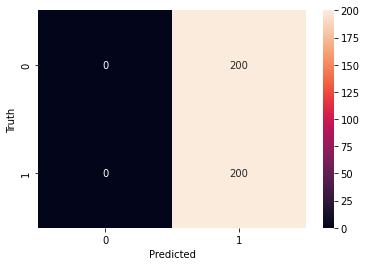

In [32]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.50      1.00      0.67       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
y_test

1394    0
416     0
974     1
156     1
1200    0
       ..
1015    1
35      1
1378    0
799     0
108     1
Name: deceptive, Length: 400, dtype: int64